In [1]:
import os
os.environ['OPENTSDB_PYTHON_METRICS_TEST_MODE'] = 'True'

In [2]:
import importlib.resources
from astropy.io import ascii
from astropy.io import fits
from banzai.calibrations import make_master_calibrations
import requests
from banzai_floyds import settings
from banzai import dbs
from banzai.utils.stage_utils import run_pipeline_stages
from banzai.utils.fits_utils import download_from_s3
import numpy as np

In [3]:
os.makedirs('test_data', exist_ok=True)
os.environ['DB_ADDRESS'] = 'sqlite:///test_data/test.db'
settings.processed_path= os.path.join(os.getcwd(), 'test_data')
settings.fpack=True
settings.db_address = os.environ['DB_ADDRESS']
settings.RAW_DATA_FRAME_URL = f'https://archive-api.lco.global/frames'

In [4]:
# set up the context object.
import banzai.main
context = banzai.main.parse_args(settings, parse_system_args=False)

In [5]:
os.system(f'banzai_floyds_create_db --db-address={os.environ["DB_ADDRESS"]}');
os.system(f'banzai_add_site --site ogg --latitude 20.7069444444	--longitude -156.258055556 --elevation 3065 --timezone -10 --db-address={os.environ["DB_ADDRESS"]}');
os.system(f'banzai_add_site --site coj --latitude -31.272932 --longitude 149.070648 --elevation 1116 --timezone 10 --db-address={os.environ["DB_ADDRESS"]}');
os.system(f'banzai_add_instrument --site ogg --camera en06 --name floyds01 --instrument-type 2m0-FLOYDS-SciCam --db-address={os.environ["DB_ADDRESS"]}');
os.system(f'banzai_add_instrument --site coj --camera en12 --name floyds02 --instrument-type 2m0-FLOYDS-SciCam --db-address={os.environ["DB_ADDRESS"]}');

In [6]:
skyflat_files = ascii.read(os.path.join(importlib.resources.files('banzai_floyds.tests'), 'data/test_skyflat.dat'))
for skyflat in skyflat_files:
    skyflat_info = dict(skyflat)
    skyflat_hdu = fits.open(download_from_s3(skyflat_info, context, is_raw_frame=True))

    # Munge the data to be OBSTYPE SKYFLAT
    skyflat_hdu['SCI'].header['OBSTYPE'] = 'SKYFLAT'
    skyflat_name = skyflat_info["filename"].replace("x00.fits", "f00.fits")
    filename = os.path.join('test_data', f'{skyflat_name}')
    skyflat_hdu.writeto(filename, overwrite=True)
    skyflat_hdu.close()
    # Process the data
    run_pipeline_stages([{'path': os.path.join(os.getcwd(), filename)}], context)

2024-01-16 11:50:40.000     INFO:      fits_utils: Downloading file ogg2m001-en06-20190329-0018-x00.fits.fz from archive. ID: 29878203. | {"filename": "ogg2m001-en06-20190329-0018-x00.fits.fz", "attempt_number": 1, "processName": "MainProcess"}
2024-01-16 11:50:44.177     INFO:          stages: Running banzai.stages.OverscanSubtractor | {"filename": "ogg2m001-en06-20190329-0018-f00.fits.fz", "site": "ogg", "instrument": "floyds01", "epoch": "20190329", "request_num": "UNSPECIFIED", "obstype": "SKYFLAT", "filter": "air", "processName": "MainProcess"}
2024-01-16 11:50:44.180     INFO:          stages: Running banzai.stages.Trimmer | {"filename": "ogg2m001-en06-20190329-0018-f00.fits.fz", "site": "ogg", "instrument": "floyds01", "epoch": "20190329", "request_num": "UNSPECIFIED", "obstype": "SKYFLAT", "filter": "air", "processName": "MainProcess"}
2024-01-16 11:50:44.180     INFO:            trim: Trimming image | {"filename": "ogg2m001-en06-20190329-0018-f00.fits.fz", "site": "ogg", "inst

In [7]:
test_data = ascii.read(os.path.join(importlib.resources.files('banzai_floyds.tests'), 'data/test_data.dat'))
for row in test_data:
    if 'a00.fits' in row['filename']:
        run_pipeline_stages([{'filename': row['filename'], 'RLEVEL': 0, 'frameid': row['frameid']}], context)

2024-01-16 11:50:54.965     INFO:      fits_utils: Downloading file coj2m002-en12-20200813-0015-a00.fits.fz from archive. ID: 33851480. | {"filename": "coj2m002-en12-20200813-0015-a00.fits.fz", "attempt_number": 1, "processName": "MainProcess"}
2024-01-16 11:50:56.926     INFO:          stages: Running banzai.stages.OverscanSubtractor | {"filename": "coj2m002-en12-20200813-0015-a00.fits.fz", "site": "coj", "instrument": "floyds02", "epoch": "20200813", "request_num": "2207712", "obstype": "ARC", "filter": "air", "processName": "MainProcess"}
2024-01-16 11:50:56.929     INFO:          stages: Running banzai.stages.Trimmer | {"filename": "coj2m002-en12-20200813-0015-a00.fits.fz", "site": "coj", "instrument": "floyds02", "epoch": "20200813", "request_num": "2207712", "obstype": "ARC", "filter": "air", "processName": "MainProcess"}
2024-01-16 11:50:56.929     INFO:            trim: Trimming image | {"filename": "coj2m002-en12-20200813-0015-a00.fits.fz", "site": "coj", "instrument": "floyds

In [8]:
import plotly.express as px

2024-01-16 11:51:12.769     INFO:           utils: Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-01-16 11:51:12.769     INFO:           utils: NumExpr defaulting to 8 threads.


In [9]:
# Download the old version of the data
for frame in test_data:
    if 'e00' in frame['filename']:
        archive_url = f'https://archive-api.lco.global/frames/{frame["frameid"]}'
        raw_frame_info = requests.get(archive_url).json()
        related_frame = raw_frame_info['related_frames'][0]
        archive_tar_url = f'https://archive-api.lco.global/frames/{related_frame}'
        frame_info = requests.get(archive_tar_url).json()
        with open(os.path.join(os.getcwd(), 'test_data', frame_info['filename']), 'wb') as f:
            f.write(requests.get(frame_info['url']).content)

In [10]:
import tarfile
from glob import glob

In [11]:
# Untar and extract the arc file deleting the rest
for filename in glob('test_data/*.tar.gz'):
    with tarfile.open(filename, 'r:gz') as f:
        for file_to_extract in f.getnames():
            if 'ttarc' == file_to_extract[:5]:
                f.extract(file_to_extract, os.path.join(os.getcwd(), 'test_data'))

In [12]:
def fits_header_to_wavelength(header):
    crval = float(header['CRVAL1'])
    crpix = float(header['CRPIX1'])
    # Convert crpix to be zero indexed
    crpix -= 1
    if 'CDELT1' in header.keys():
        cdelt = float(header['CDELT1'])
    else:
        cdelt = float(header['CD1_1'])
    npix = float(header['NAXIS1'])
    lam = np.arange(crval - cdelt * crpix ,
                    crval + cdelt * (npix - crpix) - 1e-4,
                    cdelt)
    return lam

In [13]:
from banzai_floyds.orders import orders_from_fits
from banzai_floyds.wavelengths import WavelengthSolution
from banzai_floyds.extract import get_wavelength_bins, extract, bin_data

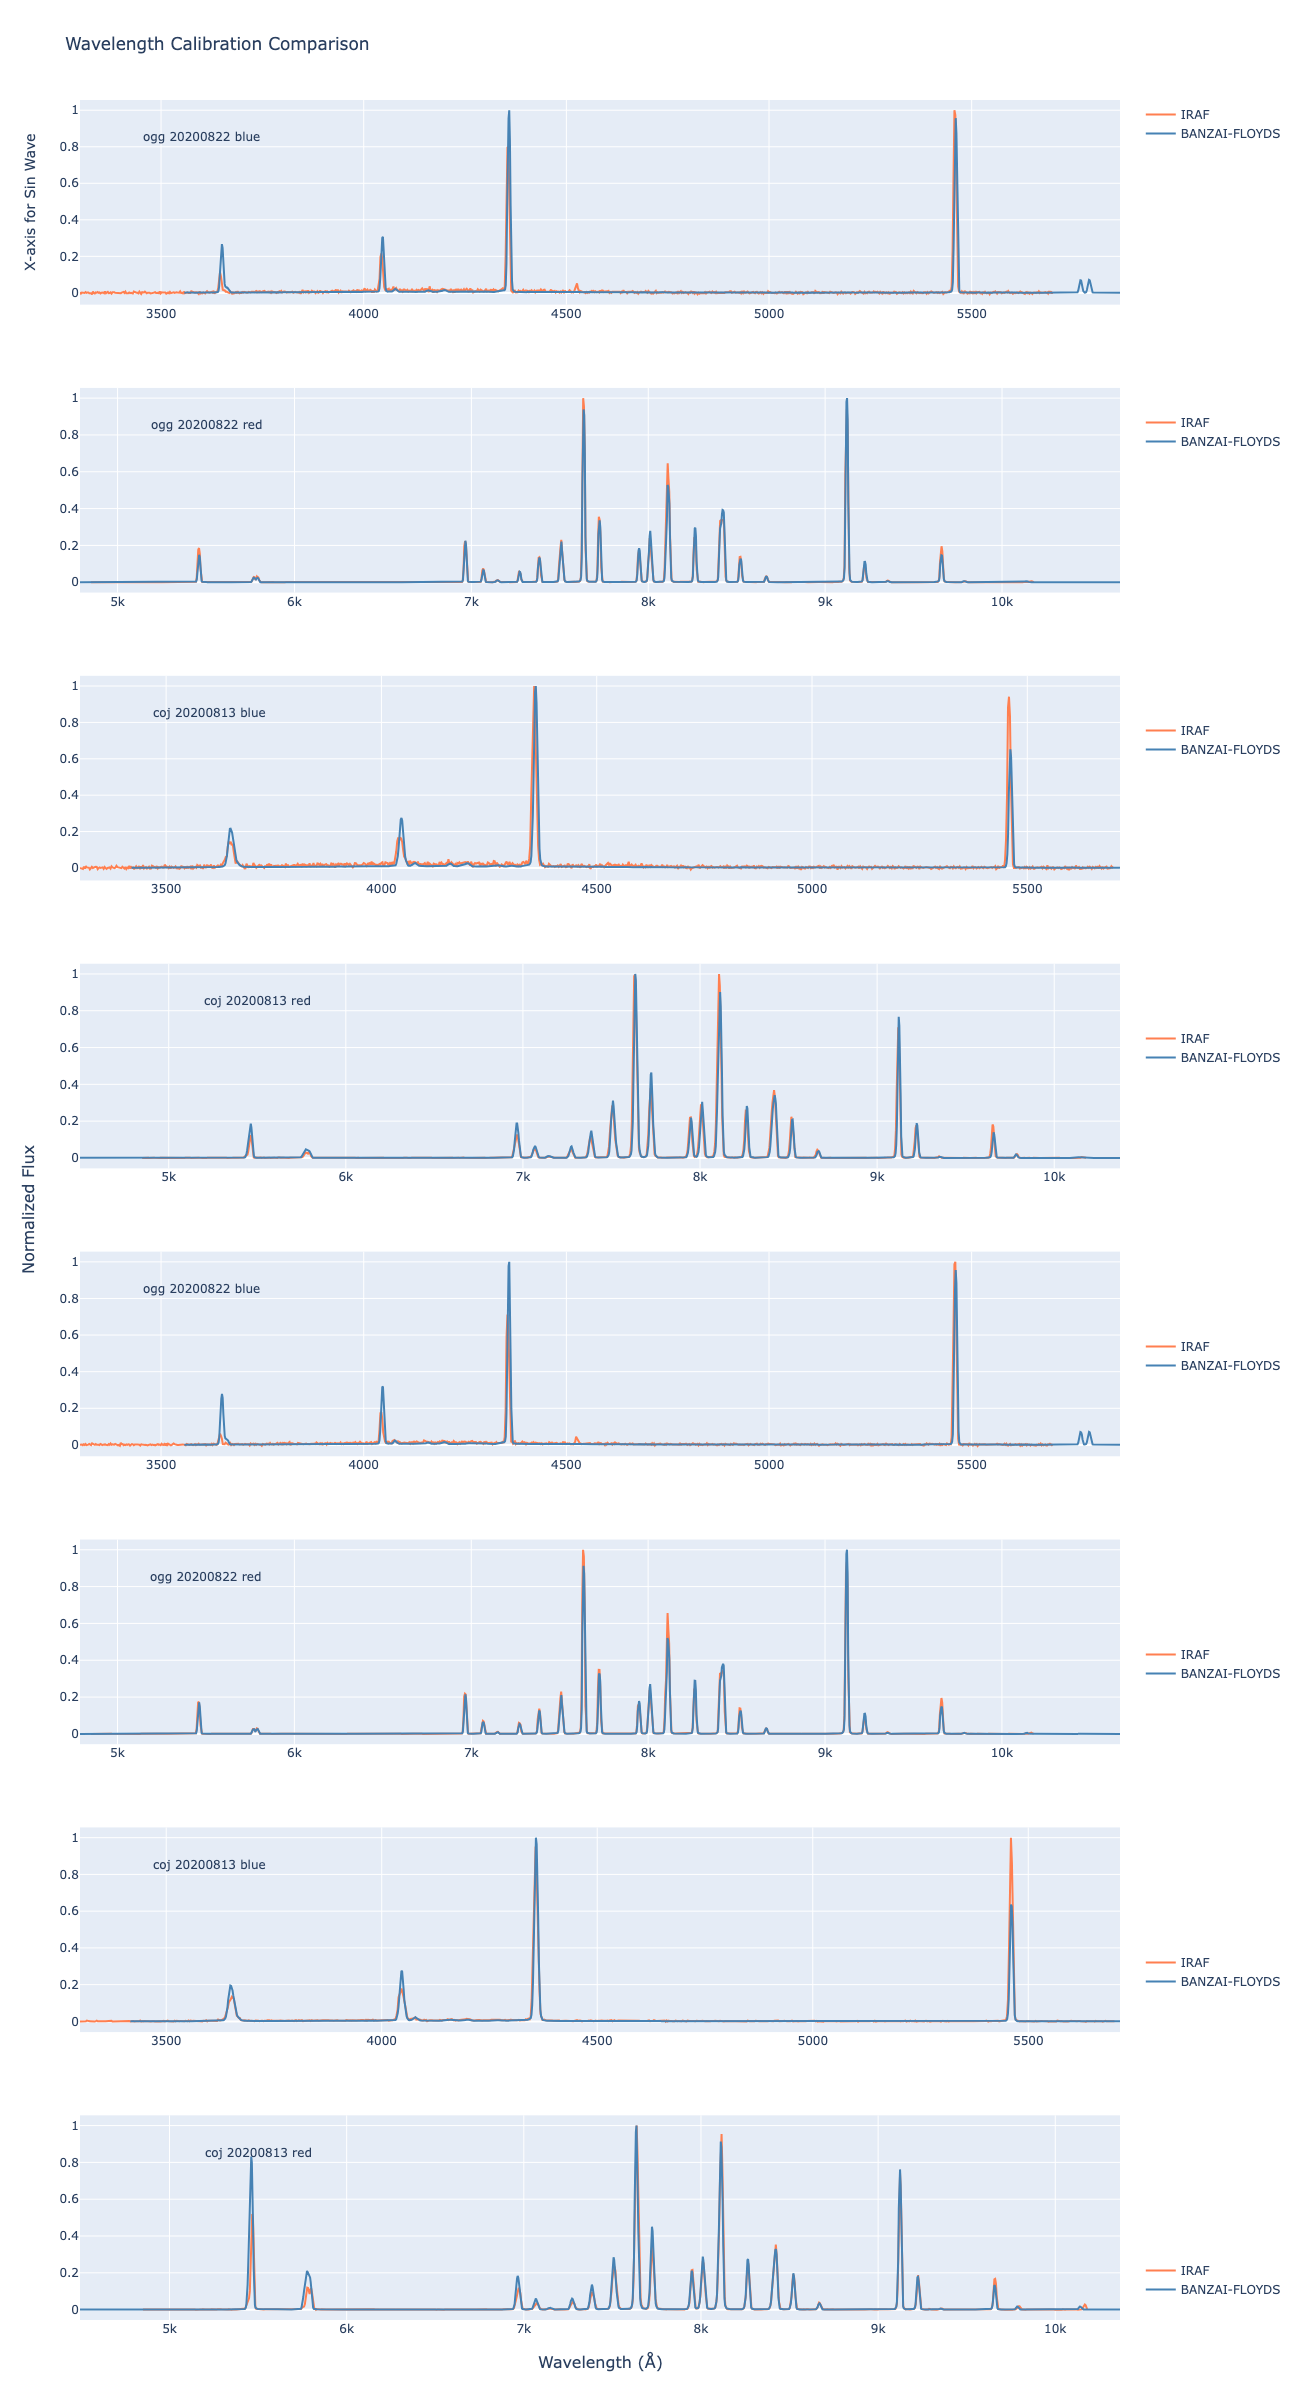

In [14]:
# Overplot the old arc on the new data blue and red
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=8, cols=1, x_title= u'Wavelength (\u212B)', y_title='Normalized Flux')

old_files = glob('test_data/ttarc_*.fits')
old_files.sort()

new_files = glob('test_data/*/*/*/processed/*a91*')
request_numbers = {}
for filename in new_files:
    hdu = fits.open(filename)
    request_numbers[hdu['SCI'].header['REQNUM']] = filename

for i, filename in enumerate(old_files):
    hdu = fits.open(filename)
    iraf_wavelengths = fits_header_to_wavelength(hdu[0].header)
    red_blue = os.path.basename(filename).split('_')[4]
    fig.add_trace(
        go.Scatter(x=iraf_wavelengths, y=hdu[0].data[0, :]/np.max(hdu[0].data[0, :]), name='IRAF',
                  line_color='coral', legendgroup=i+1),
        row=i+1, col=1,
    )
    if red_blue == 'red':
        text_x = 5500
    else:
        text_x = 3600
    fig.add_annotation(x=text_x, y=0.8,
            text=f'{hdu[0].header["SITEID"]} {hdu[0].header["DAY-OBS"]} {red_blue}',
            showarrow=False,
            yshift=10, row=i+1, col=1)
    try:
        new_filename = request_numbers[hdu[0].header['REQNUM']]
        new_hdu = fits.open(new_filename)
        orders = orders_from_fits(new_hdu['ORDER_COEFFS'].data, new_hdu['ORDER_COEFFS'].header, new_hdu['SCI'].data.shape)
        wavelengths = WavelengthSolution.from_header(new_hdu['WAVELENGTHS'].header, orders)
        wavelength_bins = get_wavelength_bins(wavelengths)
        binned_data = bin_data(new_hdu['SCI'].data, new_hdu['ERR'].data, wavelengths, orders, wavelength_bins)
        binned_data['background'] = 0.0
        binned_data['weights'] = 1.0
        extracted_data = extract(binned_data)
    
        if red_blue == 'red':
            order_to_plot = 1
        else: 
            order_to_plot = 2
        where_order = extracted_data['order'] == order_to_plot
        fig.add_trace(
            go.Scatter(x=extracted_data['wavelength'][where_order], y=extracted_data['flux'][where_order]/np.max(extracted_data['flux'][where_order]), name='BANZAI-FLOYDS',
                      line_color='steelblue', legendgroup=i+1),
            row=i+1, col=1,
        )
    except:
        continue

fig.update_layout(height=2400, width=1200, title_text="Wavelength Calibration Comparison", legend_tracegroupgap = 270,)
fig.update_yaxes(title_text="X-axis for Sin Wave", row=1, col=1)

fig.show()

In [15]:
from banzai_floyds.arc_lines import arc_lines_table
from scipy.optimize import curve_fit
from astropy.modeling import models, fitting
lines = arc_lines_table()
from banzai_floyds.wavelengths import identify_peaks, refine_peak_centers

def calculate_residuals(wavelengths, flux, flux_errors, lines):
    residuals = []
    residuals_wavelengths = []
    peaks = np.array(identify_peaks(flux, flux_errors, 4, 10, snr_threshold=15.0))
    for line in lines[lines['used']]:
        if line['wavelength'] > np.max(wavelengths) or line['wavelength'] < np.min(wavelengths):
            continue
        closest_peak = peaks[np.argmin(np.abs(wavelengths[peaks] - line['wavelength']))]
        closest_peak_wavelength = wavelengths[closest_peak]
        if np.abs(closest_peak_wavelength - line['wavelength']) <= 20:
            refined_peak = refine_peak_centers(flux, flux_errors, np.array([closest_peak]), 4)[0]
            if not np.isfinite(refined_peak): 
                continue
            if np.abs(refined_peak - closest_peak) > 5:
                continue
            refined_peak = np.interp(refined_peak, np.arange(len(wavelengths)), wavelengths)
            residuals.append(refined_peak - line['wavelength'])
            residuals_wavelengths.append(line['wavelength'])
    return np.array(residuals_wavelengths), np.array(residuals)

2024-01-16 11:51:49.513  WARNING:        warnings: /Users/cmccully/Dropbox/Mac (3)/Documents/workspace/banzai-floyds/banzai_floyds/wavelengths.py:87: RuntimeWarning:

invalid value encountered in divide


2024-01-16 11:51:49.514  WARNING:        warnings: /Users/cmccully/Dropbox/Mac (3)/Documents/workspace/banzai-floyds/banzai_floyds/wavelengths.py:88: RuntimeWarning:

divide by zero encountered in divide




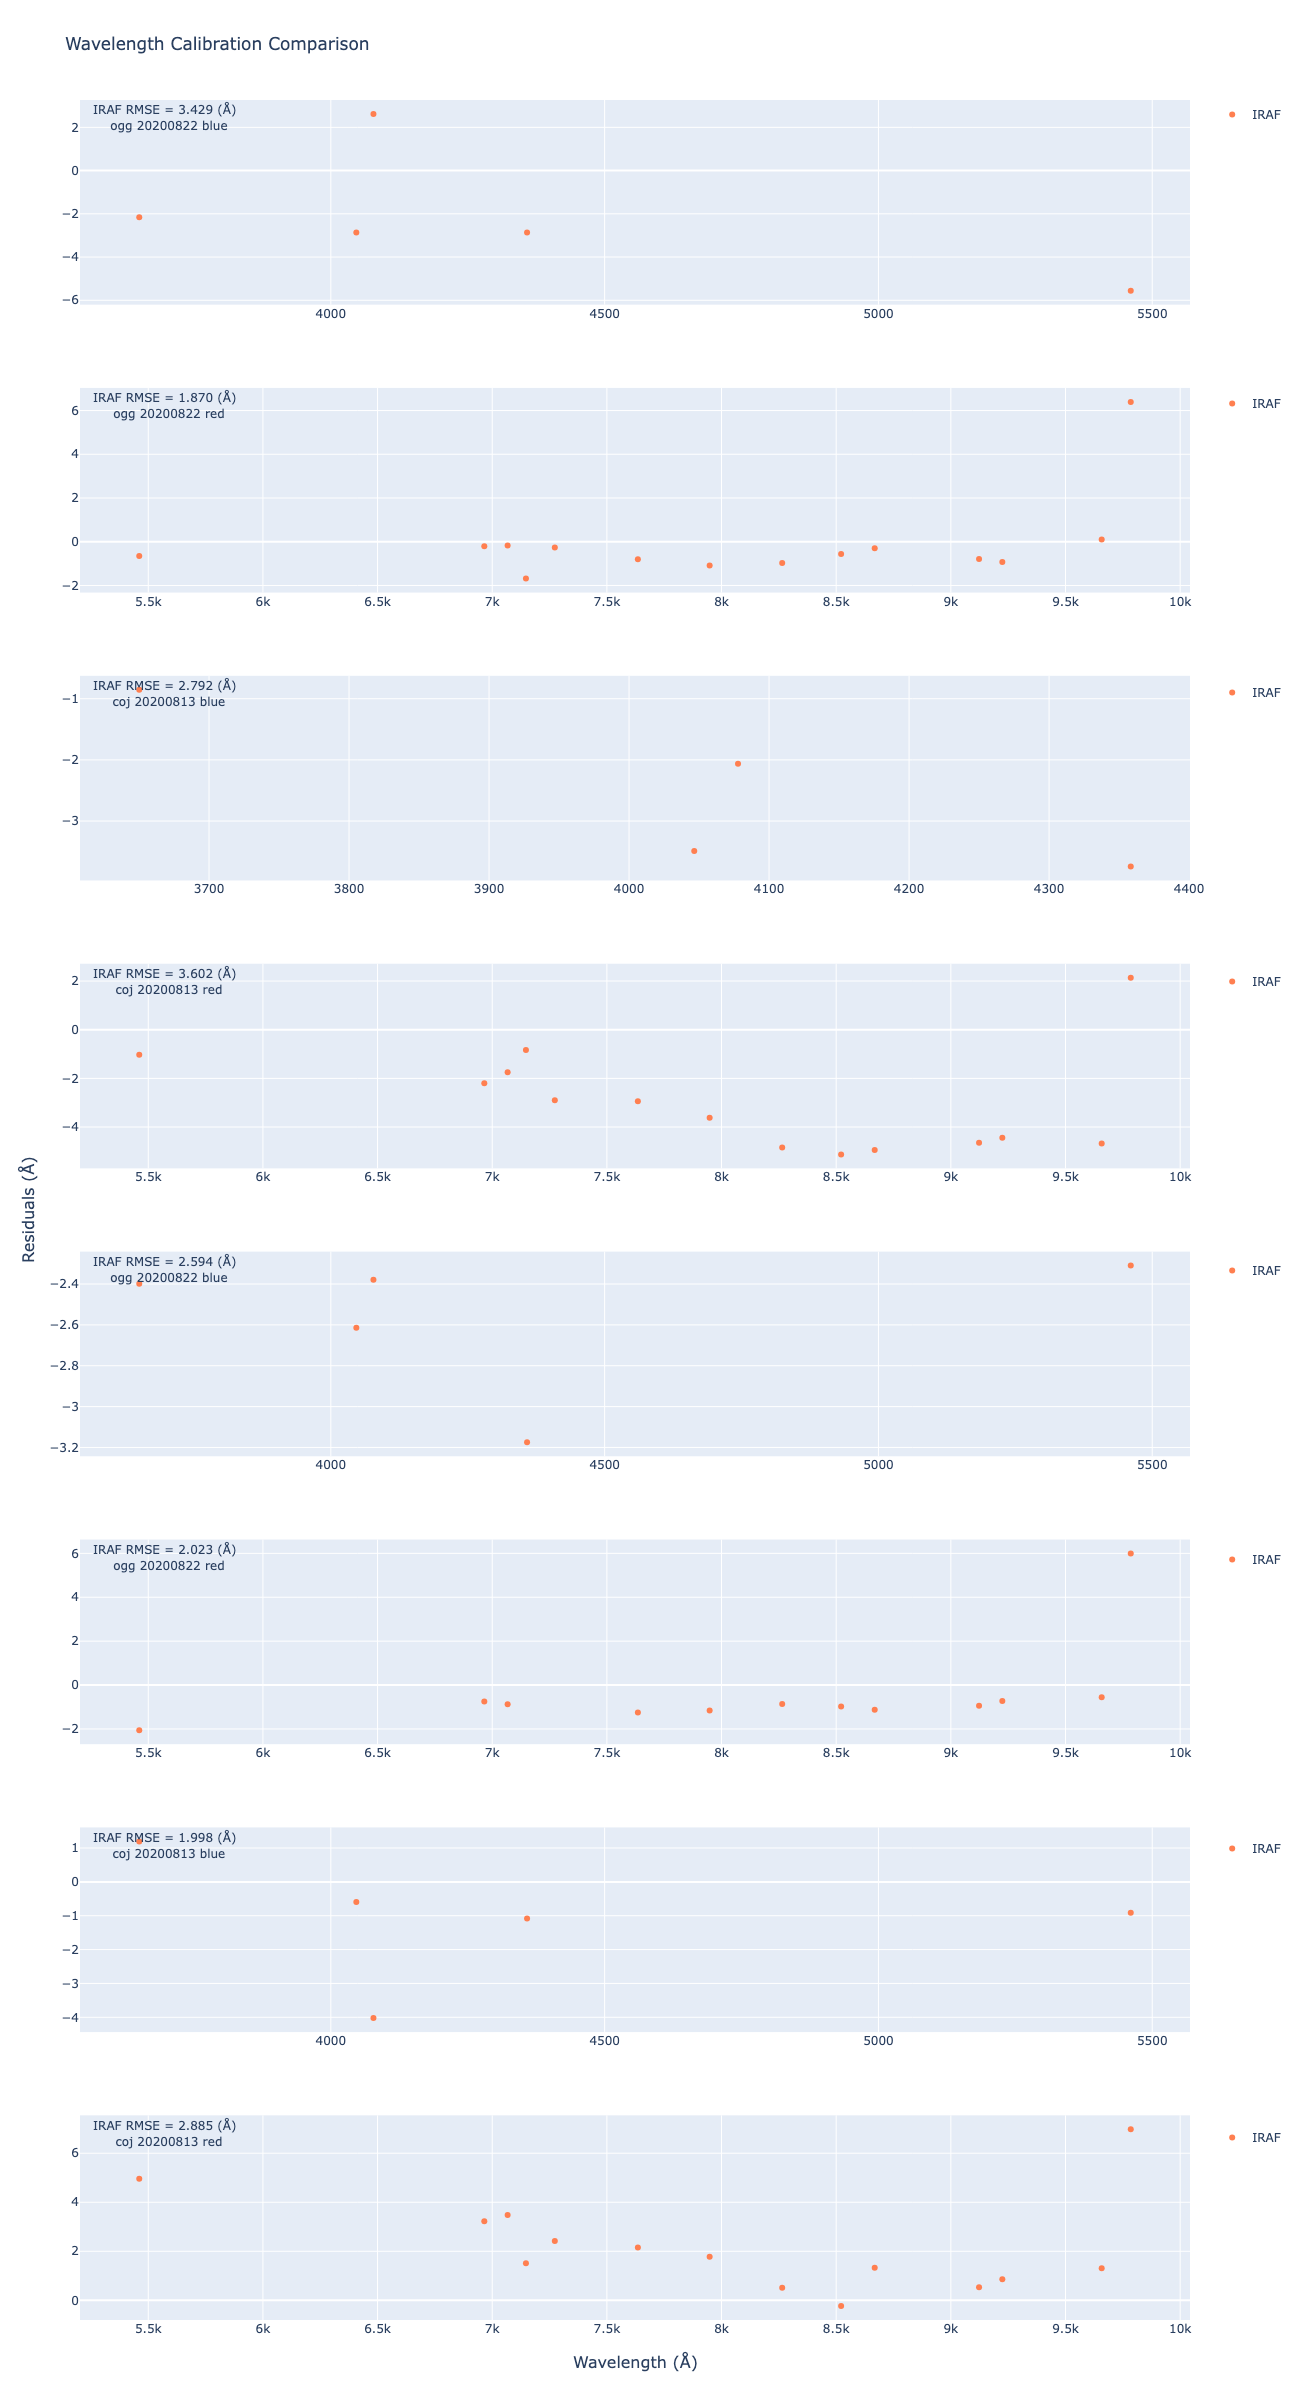

In [16]:
# plot the residuals for banzai-floyds and the iraf spectra
fig = make_subplots(rows=8, cols=1, x_title= u'Wavelength (\u212B)', y_title=u'Residuals (\u212B)')

old_files = glob('test_data/ttarc_*.fits')
old_files.sort()

new_files = glob('test_data/*/*/*/processed/*a91*')
request_numbers = {}
for filename in new_files:
    hdu = fits.open(filename)
    request_numbers[hdu['SCI'].header['REQNUM']] = filename

for i, filename in enumerate(old_files):
    hdu = fits.open(filename)
    iraf_wavelengths = fits_header_to_wavelength(hdu[0].header)
    red_blue = os.path.basename(filename).split('_')[4]

    iraf_residuals_wavelengths, iraf_residuals = calculate_residuals(iraf_wavelengths, hdu[0].data[0, :], 0.01 * hdu[0].data[0, :], lines)
    fig.add_trace(
        go.Scatter(x=iraf_residuals_wavelengths, y=iraf_residuals, name='IRAF',
                  marker_color='coral', legendgroup=i+1, mode='markers'),
        row=i+1, col=1,
    )
    if red_blue == 'red':
        text_x = 5500
    else:
        text_x = 3600
    iraf_rmse = np.sqrt(np.mean(iraf_residuals**2))

    fig.add_annotation(x=0.01, y=0.95, xref='x domain', yref='y domain',
            text=f'IRAF RMSE = {iraf_rmse:0.3f} ' + u'(\u212B) <br>' + f' {hdu[0].header["SITEID"]} {hdu[0].header["DAY-OBS"]} {red_blue}',
            showarrow=False, 
            yshift=10, row=i+1, col=1)


fig.update_layout(height=2400, width=1200, title_text="Wavelength Calibration Comparison", legend_tracegroupgap = 270,)
fig.show()

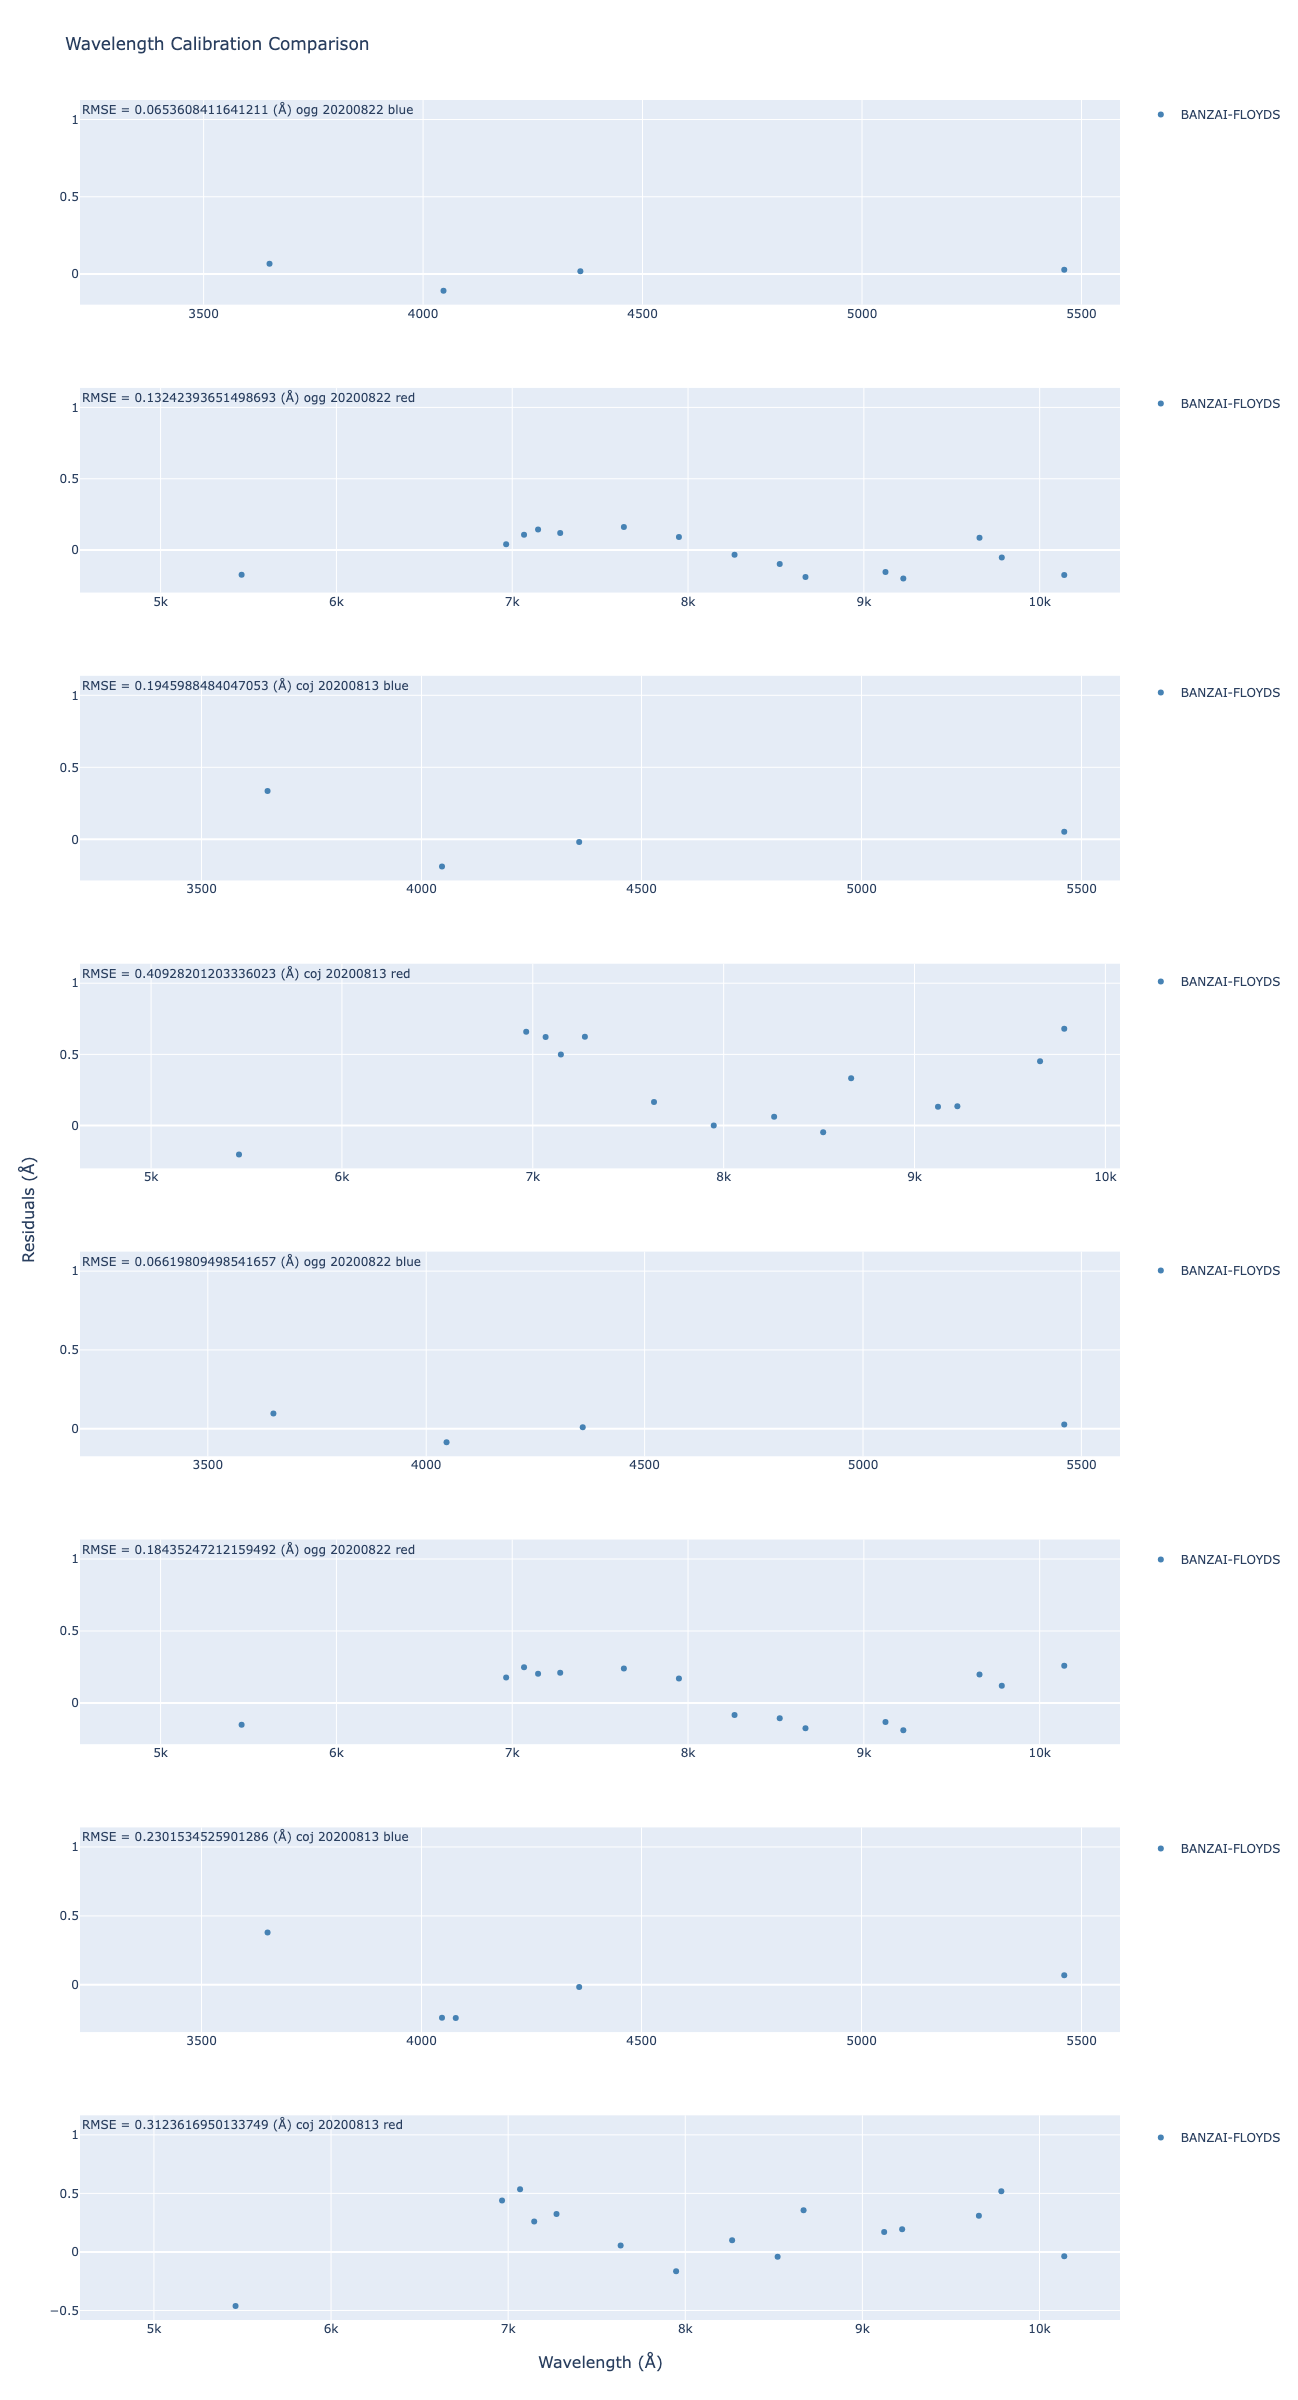

In [17]:
# plot the residuals for banzai-floyds and the iraf spectra
fig = make_subplots(rows=8, cols=1, x_title= u'Wavelength (\u212B)', y_title=u'Residuals (\u212B)')

old_files = glob('test_data/ttarc_*.fits')
old_files.sort()

new_files = glob('test_data/*/*/*/processed/*a91*')
request_numbers = {}
for filename in new_files:
    hdu = fits.open(filename)
    request_numbers[hdu['SCI'].header['REQNUM']] = filename

for i, filename in enumerate(old_files):
    hdu = fits.open(filename)
    iraf_wavelengths = fits_header_to_wavelength(hdu[0].header)
    red_blue = os.path.basename(filename).split('_')[4]
    if red_blue == 'red':
        text_x = 5500
    else:
        text_x = 3600
    iraf_rmse = np.sqrt(np.mean(iraf_residuals**2))

    new_filename = request_numbers[hdu[0].header['REQNUM']]
    new_hdu = fits.open(new_filename)
    orders = orders_from_fits(new_hdu['ORDER_COEFFS'].data, new_hdu['ORDER_COEFFS'].header, new_hdu['SCI'].data.shape)
    wavelengths = WavelengthSolution.from_header(new_hdu['WAVELENGTHS'].header, orders)
    wavelength_bins = get_wavelength_bins(wavelengths)
    binned_data = bin_data(new_hdu['SCI'].data, new_hdu['ERR'].data, wavelengths, orders, wavelength_bins)
    binned_data['background'] = 0.0
    binned_data['weights'] = 1.0
    extracted_data = extract(binned_data)

    if red_blue == 'red':
        order_to_plot = 1
    else: 
        order_to_plot = 2
    where_order = extracted_data['order'] == order_to_plot
    residuals_wavelengths, residuals = calculate_residuals(extracted_data['wavelength'][where_order], extracted_data['flux'][where_order], extracted_data['fluxerror'][where_order], lines)
    fig.add_trace(
        go.Scatter(x=residuals_wavelengths, y=residuals, name='BANZAI-FLOYDS',
                  marker_color='steelblue', legendgroup=i+1, mode='markers'),
        row=i+1, col=1,
    )
    rmse = np.sqrt(np.mean(residuals **2))
    fig.add_annotation(x=text_x, y=1.0,
            text=f'RMSE = {rmse} ' + u'(\u212B)' + f' {hdu[0].header["SITEID"]} {hdu[0].header["DAY-OBS"]} {red_blue}',
            showarrow=False,
            yshift=10, row=i+1, col=1)


fig.update_layout(height=2400, width=1200, title_text="Wavelength Calibration Comparison", legend_tracegroupgap = 270,)
fig.show()